In [1]:
import os
import torch
import numpy as np
import pandas as pd

from torch.utils.data import DataLoader

from whale_imitation import *

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [2]:
CSV_PATH = "sperm-whale-dialogues.csv"

assert os.path.exists(CSV_PATH), f"Missing {CSV_PATH}. Put it next to the notebook or update CSV_PATH."

df = load_csv(CSV_PATH)
df.head(), df.shape

(             REC  nClicks  Duration      ICI1      ICI2      ICI3      ICI4  \
 0  sw061b001_124       17  0.927792  0.033950  0.036117  0.048867  0.048908   
 1  sw061b001_124       20  1.092992  0.032817  0.039358  0.045325  0.049933   
 2  sw061b001_124        5  0.898250  0.275850  0.286783  0.197400  0.138217   
 3  sw061b001_124        5  0.865575  0.262275  0.276883  0.183333  0.143083   
 4  sw061b001_124        5  0.858317  0.266675  0.269358  0.178325  0.143958   
 
        ICI5      ICI6      ICI7  ...  ICI21  ICI22  ICI23  ICI24  ICI25  \
 0  0.042275  0.040483  0.040975  ...    0.0    0.0    0.0    0.0    0.0   
 1  0.044083  0.044783  0.043683  ...    0.0    0.0    0.0    0.0    0.0   
 2  0.000000  0.000000  0.000000  ...    0.0    0.0    0.0    0.0    0.0   
 3  0.000000  0.000000  0.000000  ...    0.0    0.0    0.0    0.0    0.0   
 4  0.000000  0.000000  0.000000  ...    0.0    0.0    0.0    0.0    0.0   
 
    ICI26  ICI27  ICI28  Whale      TsTo  
 0    0.0    0.0 

In [3]:
train_recs, val_recs, test_recs = split_recs(df, val_frac=0.1, test_frac=0.0, seed=0)

print("Num conversations (REC):", df["REC"].nunique())
print("Train RECs:", len(train_recs))
print("Val RECs:", len(val_recs))
print("Test RECs:", len(test_recs))

Num conversations (REC): 219
Train RECs: 197
Val RECs: 22
Test RECs: 0


In [4]:
cfg = BCConfig(
    hidden_size=256,
    num_layers=1,
    dropout=0.0,
    use_log_ici=True,
)

train_ds = WhaleBCDataset(CSV_PATH, cfg=cfg, recs=train_recs)
val_ds   = WhaleBCDataset(CSV_PATH, cfg=cfg, recs=val_recs, ici_mean=train_ds.ici_mean, ici_std=train_ds.ici_std)

print("Train episodes (rows):", len(train_ds))
print("Val episodes (rows):", len(val_ds))
print("Num whales (mapped):", train_ds.n_whales)
print("ICI norm mean/std:", train_ds.ici_mean, train_ds.ici_std)

Train episodes (rows): 3521
Val episodes (rows): 319
Num whales (mapped): 10
ICI norm mean/std: -1.8894754295816543 0.8070952322128051


In [5]:
BATCH_TRAIN = 32
BATCH_VAL   = 64

train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_TRAIN,
    shuffle=True,
    collate_fn=lambda b: collate_bc(b, cfg=cfg),
    num_workers=0,
)

val_loader = DataLoader(
    val_ds,
    batch_size=BATCH_VAL,
    shuffle=False,
    collate_fn=lambda b: collate_bc(b, cfg=cfg),
    num_workers=0,
)

In [6]:
model = GRUBCModel(n_whales=train_ds.n_whales, cfg=cfg)
model

GRUBCModel(
  (whale_emb): Embedding(10, 32)
  (type_emb): Embedding(4, 16)
  (gru): GRU(49, 256, batch_first=True)
  (head_eos): Linear(in_features=256, out_features=1, bias=True)
  (head_ici): Linear(in_features=256, out_features=1, bias=True)
)

In [7]:
pre_val = evaluate_bc(model, val_loader, device=device)
pre_val

{'loss_total': 1.6841306209564209,
 'loss_eos': 0.6759636878967286,
 'loss_ici': 1.0081669569015503}

In [8]:
history = train_bc(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=10,
    lr=1e-3,
    device=device,
)

history[:2], history[-2:]

BC train ep 1/10:   0%|          | 0/111 [00:00<?, ?it/s]

[BC] ep 1/10 train_total=0.7620 train_eos=0.3350 train_ici=0.4270 | val_total=0.4483 val_eos=0.1758 val_ici=0.2724


BC train ep 2/10:   0%|          | 0/111 [00:00<?, ?it/s]

[BC] ep 2/10 train_total=0.3938 train_eos=0.1645 train_ici=0.2293 | val_total=0.3751 val_eos=0.1365 val_ici=0.2387


BC train ep 3/10:   0%|          | 0/111 [00:00<?, ?it/s]

[BC] ep 3/10 train_total=0.3608 train_eos=0.1452 train_ici=0.2157 | val_total=0.3622 val_eos=0.1291 val_ici=0.2331


BC train ep 4/10:   0%|          | 0/111 [00:00<?, ?it/s]

[BC] ep 4/10 train_total=0.3344 train_eos=0.1311 train_ici=0.2033 | val_total=0.3371 val_eos=0.1044 val_ici=0.2328


BC train ep 5/10:   0%|          | 0/111 [00:00<?, ?it/s]

[BC] ep 5/10 train_total=0.3215 train_eos=0.1223 train_ici=0.1991 | val_total=0.3173 val_eos=0.0951 val_ici=0.2222


BC train ep 6/10:   0%|          | 0/111 [00:00<?, ?it/s]

[BC] ep 6/10 train_total=0.3036 train_eos=0.1095 train_ici=0.1941 | val_total=0.2991 val_eos=0.0866 val_ici=0.2126


BC train ep 7/10:   0%|          | 0/111 [00:00<?, ?it/s]

[BC] ep 7/10 train_total=0.2932 train_eos=0.1005 train_ici=0.1926 | val_total=0.2937 val_eos=0.0860 val_ici=0.2077


BC train ep 8/10:   0%|          | 0/111 [00:00<?, ?it/s]

[BC] ep 8/10 train_total=0.2803 train_eos=0.0935 train_ici=0.1868 | val_total=0.2878 val_eos=0.0759 val_ici=0.2119


BC train ep 9/10:   0%|          | 0/111 [00:00<?, ?it/s]

[BC] ep 9/10 train_total=0.2662 train_eos=0.0902 train_ici=0.1760 | val_total=0.2784 val_eos=0.0809 val_ici=0.1975


BC train ep 10/10:   0%|          | 0/111 [00:00<?, ?it/s]

[BC] ep 10/10 train_total=0.2531 train_eos=0.0826 train_ici=0.1705 | val_total=0.2726 val_eos=0.0728 val_ici=0.1997


([{'epoch': 1.0,
   'train_loss_total': 0.7620065080689954,
   'train_loss_eos': 0.3349981985247887,
   'train_loss_ici': 0.427008307664781,
   'val_loss_total': 0.4482584953308105,
   'val_loss_eos': 0.1758140042424202,
   'val_loss_ici': 0.2724444895982742},
  {'epoch': 2.0,
   'train_loss_total': 0.39378486103839705,
   'train_loss_eos': 0.16452941566974194,
   'train_loss_ici': 0.22925544291029912,
   'val_loss_total': 0.37513881325721743,
   'val_loss_eos': 0.13645156025886535,
   'val_loss_ici': 0.2386872485280037}],
 [{'epoch': 9.0,
   'train_loss_total': 0.2661895075695472,
   'train_loss_eos': 0.09015239624994563,
   'train_loss_ici': 0.1760371116048715,
   'val_loss_total': 0.2783511772751808,
   'val_loss_eos': 0.08088120669126511,
   'val_loss_ici': 0.1974699690937996},
  {'epoch': 10.0,
   'train_loss_total': 0.2531170791837278,
   'train_loss_eos': 0.08259658381628159,
   'train_loss_ici': 0.17052049604286482,
   'val_loss_total': 0.27256873846054075,
   'val_loss_eos': 0

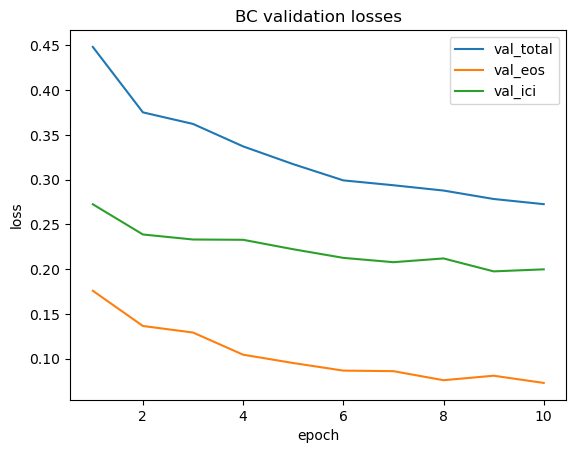

In [9]:
import matplotlib.pyplot as plt

epochs = [h["epoch"] for h in history]
val_total = [h.get("val_loss_total", np.nan) for h in history]
val_eos   = [h.get("val_loss_eos", np.nan) for h in history]
val_ici   = [h.get("val_loss_ici", np.nan) for h in history]

plt.figure()
plt.plot(epochs, val_total, label="val_total")
plt.plot(epochs, val_eos, label="val_eos")
plt.plot(epochs, val_ici, label="val_ici")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.title("BC validation losses")
plt.show()

In [10]:
# Choose an episode index from val set
episode_index = 0

ex = val_ds[episode_index]

# Find SOC index; everything before it is history
soc_idx = ex["tok_types"].index(cfg.TOK_SOC)

history_tokens = list(zip(
    ex["whale_ids"][:soc_idx],
    ex["tok_types"][:soc_idx],
    ex["ici_feats"][:soc_idx],
))

current_whale = ex["whale_ids"][soc_idx]

gen = rollout_coda(
    model=model,
    history_tokens=history_tokens,
    current_whale=current_whale,
    max_len=cfg.max_ici_cols,  # max ICIs to generate
    ici_mean=val_ds.ici_mean,
    ici_std=val_ds.ici_std,
    eos_threshold=0.5,
    device=device,
)

print("Generated ICI count:", len(gen))
print("Generated ICIs:", gen[:10], "..." if len(gen) > 10 else "")

Generated ICI count: 4
Generated ICIs: [0.16773961934581116, 0.18035005524690706, 0.13268307701665183, 0.11782870885558953] 


In [11]:
# Extract the real coda ICIs for this episode from the dataset tensors
# ex contains normalized feats; convert back to raw ICIs for the real ICIs after SOC until EOS.

real_feats = []
for tt, f in zip(ex["tok_types"][soc_idx+1:], ex["ici_feats"][soc_idx+1:]):
    if tt == cfg.TOK_EOS:
        break
    if tt == cfg.TOK_ICI:
        real_feats.append(float(f))

from whale_imitation import feat_to_ici

real_ici = [feat_to_ici(f, cfg, val_ds.ici_mean, val_ds.ici_std) for f in real_feats]

print("Real ICI count:", len(real_ici))
print("Real ICIs:", real_ici[:10], "..." if len(real_ici) > 10 else "")

# Simple side-by-side for first min length
m = min(len(real_ici), len(gen))
pairs = list(zip(real_ici[:m], gen[:m]))
pairs[:10]

Real ICI count: 16
Real ICIs: [0.03395, 0.036116600000000006, 0.0488667, 0.0489083, 0.04227499999999999, 0.040483399999999996, 0.040975, 0.03960829999999999, 0.0421334, 0.04169160000000001] ...


[(0.03395, 0.16773961934581116),
 (0.036116600000000006, 0.18035005524690706),
 (0.0488667, 0.13268307701665183),
 (0.0489083, 0.11782870885558953)]

In [12]:
from whale_imitation import (
    GRUDiscriminator, DiscConfig,
    make_disc_loader_from_dataset,
    train_discriminator, evaluate_discriminator,
)

# How many episode pairs to sample for the discriminator dataset
NUM_PAIRS = min(1000, len(val_ds))   # increase if you have enough data
DISC_BATCH = 32
MAX_GEN_LEN = cfg.max_ici_cols
EOS_THRESH = 0.5

disc_loader = make_disc_loader_from_dataset(
    ds=val_ds,
    bc_model=model,
    num_pairs=NUM_PAIRS,
    batch_size=DISC_BATCH,
    max_len=MAX_GEN_LEN,
    eos_threshold=EOS_THRESH,
    shuffle=True,
    seed=0,
    device_for_generation=device,   # generation can be on GPU if available
)

print("Discriminator examples (real+fake):", 2 * NUM_PAIRS)

Discriminator examples (real+fake): 638


In [13]:
disc_cfg = DiscConfig(
    hidden_size=256,
    num_layers=1,
    dropout=0.0,
)

disc = GRUDiscriminator(
    n_whales=val_ds.n_whales,
    cfg=disc_cfg,
    bc_cfg=cfg,
)

pre = evaluate_discriminator(disc, disc_loader, device=device)
pre

{'disc_acc': 0.4952978056426332, 'disc_auc': 0.5062450251078507}

In [14]:
disc_hist = train_discriminator(
    disc=disc,
    loader=disc_loader,
    epochs=5,
    lr=1e-3,
    device=device,
)

disc_hist

DISC train ep 1/5:   0%|          | 0/20 [00:00<?, ?it/s]

[DISC] ep 1/5 loss=0.7043


DISC train ep 2/5:   0%|          | 0/20 [00:00<?, ?it/s]

[DISC] ep 2/5 loss=0.7138


DISC train ep 3/5:   0%|          | 0/20 [00:00<?, ?it/s]

[DISC] ep 3/5 loss=0.6996


DISC train ep 4/5:   0%|          | 0/20 [00:00<?, ?it/s]

[DISC] ep 4/5 loss=0.6972


DISC train ep 5/5:   0%|          | 0/20 [00:00<?, ?it/s]

[DISC] ep 5/5 loss=0.6968


[{'epoch': 1.0, 'disc_loss': 0.704317718744278},
 {'epoch': 2.0, 'disc_loss': 0.7138014107942581},
 {'epoch': 3.0, 'disc_loss': 0.6995841234922409},
 {'epoch': 4.0, 'disc_loss': 0.6972110718488693},
 {'epoch': 5.0, 'disc_loss': 0.696789026260376}]

In [15]:
post = evaluate_discriminator(disc, disc_loader, device=device)
post

{'disc_acc': 0.5266457680250783, 'disc_auc': 0.5350576350468254}

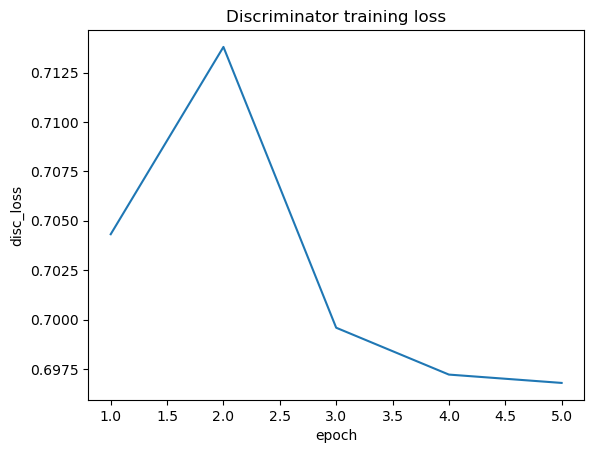

In [16]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot([h["epoch"] for h in disc_hist], [h["disc_loss"] for h in disc_hist])
plt.xlabel("epoch")
plt.ylabel("disc_loss")
plt.title("Discriminator training loss")
plt.show()

In [17]:
print("Discriminator accuracy:", post["disc_acc"])
print("Discriminator AUROC:", post["disc_auc"])

if np.isfinite(post["disc_auc"]):
    if post["disc_auc"] > 0.8:
        print("-> Discriminator can easily tell real vs generated (BC rollouts not very realistic yet).")
    elif post["disc_auc"] > 0.65:
        print("-> Discriminator has moderate power; BC is partially matching structure.")
    else:
        print("-> Discriminator struggles to separate; generated episodes look relatively real (or disc is underfit).")

Discriminator accuracy: 0.5266457680250783
Discriminator AUROC: 0.5350576350468254
-> Discriminator struggles to separate; generated episodes look relatively real (or disc is underfit).
